In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ddutils import *

import seaborn as sns # optional

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

The data for this paper can be obtained here
- [Link to all data](https://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluationhttps://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluationhttps://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluationhttps://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluation)
- Specific file: 'SFpark_ParkingSensorData_HourlyOccupancy_20112013.csv'

In [4]:
df = pd.read_csv('./SFpark_ParkingSensorData_HourlyOccupancy_20112013.csv')
print("Available Sub-Areas : ", df.PM_DISTRICT_NAME.unique())

/var/folders/4j/4svhn30n7tb4l7xvn6prn48w0000gn/T/ipykernel_34962/1762443942.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./SFpark_ParkingSensorData_HourlyOccupancy_20112013.csv')


Available Sub-Areas :  ['Fillmore' 'Downtown' 'Inner Richmond' 'West Portal' 'South Embarcadero'
 'Marina' "Fisherman's Wharf" 'Civic Center' 'Mission' 'Union' nan]


## Run the following model for a single street
Runs both zero and first order and plots

Loss is
$$\mathbb{E}_{q\sim \mathcal{D}}\left[\frac{1}{2}(q+m\theta-0.7)^2+\frac{\gamma}{2}\theta^2\right]$$
for $q\sim \mathcal{D}$.
Hence the gradient with respect to $\theta$ is
$$\nabla L(\theta)=\mathbb{E}_{q\sim \mathcal{D}}\left[(q+m\theta-0.7)m+\gamma\theta\right]$$

For $q\sim d_t=\delta^n d_{t-1}+(1-\delta^n)\mathcal{D}(\theta)$, the loss is
$$\mathbb{E}_{q\sim d_t}\left[\frac{1}{2}(q+m\theta-0.7)^2+\frac{\gamma}{2}\theta^2\right]$$

In [38]:
street_name = "BEACH ST"
daytype="weekday"
beach_district_name = "Fisherman's Wharf"
df_beach_st = df[(df.STREET_NAME==street_name) & (df.PM_DISTRICT_NAME==beach_district_name)]
pre_occ = df_beach_st[(df_beach_st['DAY_TYPE']==daytype)]

starting_rate=3.0
Rmin=-starting_rate; Rmax=8-starting_rate

ddp=ddproblem(0.9,int(1e4),int(1e6),theta_init=0, Rmin=Rmin, Rmax=Rmax)

timewin=(1200,1400)
blk=600

ddp.setup(street_name, blk, timewin, pre_occ, starting_rate, num_days=5)

## Running First Order

In [6]:
pairs=[(1, 120),(8, 15), (40, 3)]
ddp.runFOgrad(pairs)

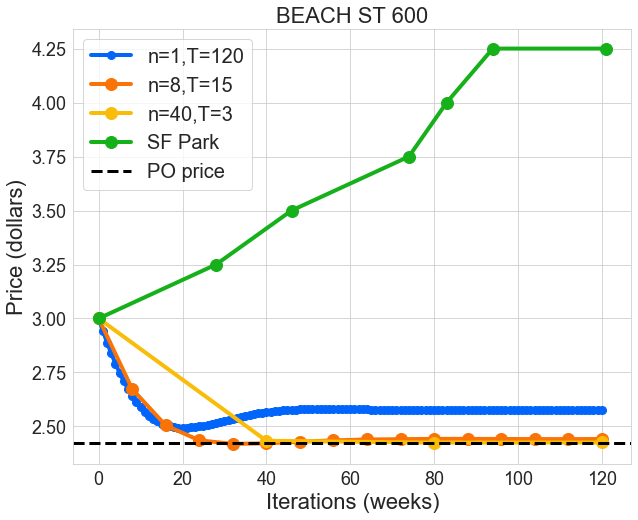

In [7]:
plt.figure(figsize=(10,8))
palette = ['xkcd:bright blue', 'xkcd:orange', 'xkcd:golden rod', 'xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple'] #sns.color_palette("tab10", 5)
sns.set_style("whitegrid")

final_price_lst=[]
for seed in ddp.seeds:
    for i,p in enumerate(pairs):
        n=p[0]; T=p[1]
        total = n*T
        x_coords = range(0, total + 1, n)
        marker = '-o'
        if n <= 3:
            markersize = 8
        else:
            markersize=12

        y_coords = np.asarray(ddp.data_current_run_fo[p,seed])+starting_rate
        final_price_lst.append(((n, T), y_coords[-1], estimate_occupancy(ddp.m, ddp.q, y_coords[-1]-starting_rate)))
        plt.plot(x_coords, y_coords, marker, color=palette[i], linewidth=4, markersize=markersize, label="n={},T={}".format(n, T))

plt.plot(ddp.sf_park_xcoords, ddp.sf_park_ycoords, marker, color="xkcd:green", linewidth=4, markersize=markersize, label="SF Park")

final_price_lst.append(("SF Park", ddp.sf_park_ycoords[-1], estimate_occupancy(ddp.m, ddp.q, ddp.sf_park_ycoords[-1]-starting_rate)))
final_price_lst.append(("PO PRICE", ddp.theta_opt+starting_rate, estimate_occupancy(ddp.m, ddp.q, ddp.theta_opt)))
final_price_lst.append(("FINAL OCCUPANCY FROM DATA", ddp.sf_park_ycoords[-1], ddp.end_occ))

plt.axhline(y=ddp.theta_opt+starting_rate, linestyle='--', color='xkcd:black', label=r'PO price', linewidth=3)
plt.legend(fontsize=20)
plt.xlabel('Iterations (weeks)', fontsize=22)
plt.ylabel('Price (dollars)', fontsize=22)
plt.tick_params(labelsize=18)
plt.title("{0} {1}".format(street_name, blk), fontsize=22)

#plt.savefig('./figs/{0}_{1}_FO_plot_FILLMORE.pdf'.format(street_name, blk))

plt.show()

#final_prices[blk] = final_price_lst

## Running Zero Order

In [10]:
beach_street_name = "BEACH ST"
df_beachst = df[(df.STREET_NAME==beach_street_name) & (df.PM_DISTRICT_NAME==beach_district_name)]
assert df_beachst.AREA_TYPE.unique() == ["Pilot"]
pre_occ_beach = df_beachst[(df_beachst['DAY_TYPE']=='weekday')]
beach_blocks = find_block_nums(df_beachst, beach_street_name)

In [46]:
data_600 = ddp.runZOgrad_(beach_street_name, 600, 3.00, 
                         pre_loaded_dataset=pre_occ_beach,pairs=[(1, 120),(8, 15), (40, 3)]) 

m: -0.15522230336700335
$\delta$: 0.958153801777585
M=  0.6314437815952229


In [49]:
#pairs=[(1, 120),(8, 15), (40, 3)]
#data_600 = zo_run(beach_street_name, 600, 3.00, 
#                         pre_loaded_dataset=pre_occ_beach,pairs=[(1, 120),(8, 15), (40, 3)])    # beach street rates start at 3.00

0
1
2


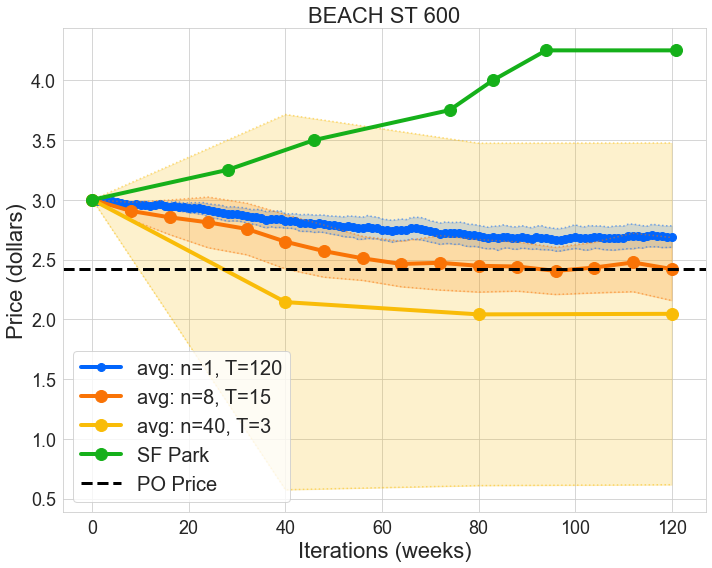

In [48]:
#ddp.runZOgrad(pairs)
#data_600

plt.figure(figsize=(10,8))
palette = ['xkcd:bright blue', 'xkcd:orange', 'xkcd:golden rod', 'xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple'] #sns.color_palette("tab10", 5)
sns.set_style("whitegrid")

final_price_lst=[]
ci=0

plotit = ddp.zo_vars #data_600['vari']
for i,p in enumerate(pairs):
    n=p[0]; T=p[1]
    total = n*T
    x_coords = range(0, total + 1, n)
    marker = '-o'
    if n <= 3:
        markersize = 8
    else:
        markersize=12

    y_coords = np.asarray(ddp.zo_avgs[p])+starting_rate
    final_price_lst.append(((n, T), y_coords[-1], estimate_occupancy(ddp.m, ddp.q, y_coords[-1]-starting_rate)))

    plt.plot(x_coords,np.asarray(ddp.zo_avgs[p])+starting_rate,label="avg: n={}, T={}".format(n, T), linewidth=4, 
             color=palette[ci], marker='o', markersize=markersize)
    
    plt.plot(x_coords,(np.asarray(ddp.zo_avgs[p])+starting_rate+np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),), 
             color=palette[ci], linestyle=':', alpha=0.5) #, label=r'$\pm 1$ std')
    plt.plot(x_coords,(np.asarray(ddp.zo_avgs[p])+starting_rate-np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),), 
             color=palette[ci], linestyle=':', alpha=0.5)
    plt.fill_between(x_coords,(np.asarray(ddp.zo_avgs[p])+starting_rate+np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),),
                     (np.asarray(ddp.zo_avgs[p])+starting_rate-np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),), alpha=0.2, color=palette[ci])
    print(ci)

    ci+=1

plt.plot(ddp.sf_park_xcoords, ddp.sf_park_ycoords, marker, color="xkcd:green", linewidth=4, markersize=markersize, label="SF Park")

final_price_lst.append(("SF Park", ddp.sf_park_ycoords[-1], estimate_occupancy(ddp.m, ddp.q, ddp.sf_park_ycoords[-1]-starting_rate)))
final_price_lst.append(("PO PRICE", ddp.theta_opt+starting_rate, estimate_occupancy(ddp.m, ddp.q, ddp.theta_opt)))

plt.axhline(y=ddp.theta_opt+starting_rate, linestyle='--', color='xkcd:black', label="PO Price", linewidth=3)
plt.legend(fontsize=20)
plt.xlabel('Iterations (weeks)', fontsize=22)
plt.ylabel('Price (dollars)', fontsize=22)
plt.tick_params(labelsize=18)
plt.title("{0} {1}".format(street_name, blk), fontsize=22)
plt.tight_layout()


plt.show()

## Run multiple blocks and generate bar chart
(will generate bar charts from the paper, increase the number of seeds to reduce the variance)

In [50]:
#### Working for paper
_df=df[df['PM_DISTRICT_NAME']=="South Embarcadero"]
_df=pd.concat([_df,df[df['PM_DISTRICT_NAME']=="Downtown"]])

blks_all=[ 0,100, 500, 600] 
street_names_all=[  "HAWTHORNE ST", "FOLSOM ST"] 
def getdatas(street_names_all,df_dse, blks_all):
    preoccs={}
    for i,street_name in enumerate(street_names_all):
        df_3 = df_dse[df_dse['STREET_NAME']==street_name]
        preoccs[street_name] = df_dse[(df_dse['DAY_TYPE']=='weekday') & (df_dse['STREET_NAME']==street_name)]
            
    blks_3rd=blks_all 
    
    return df_3, blks_3rd, preoccs

blks_all=[ 0,100, 500, 600] #, 500] #200,300,
street_names_all=[  "HAWTHORNE ST",   "HAWTHORNE ST", "FOLSOM ST", "FOLSOM ST"] 

df_3, blks_3rd, preoccs=getdatas(street_names_all, _df, blks_all)

In [51]:


starting_rate=3.0
Rmin=-starting_rate; Rmax=8-starting_rate

ddp=ddproblem(0.9,int(1e4),int(1e6),theta_init=0, Rmin=Rmin, Rmax=Rmax)



m: 0.24750992874779554
$\delta$: 0.8356784345594098
M=  0.683077511985755


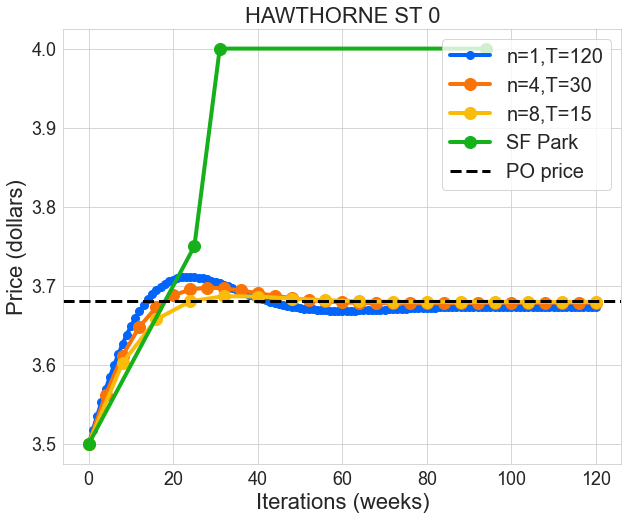

0
1
2


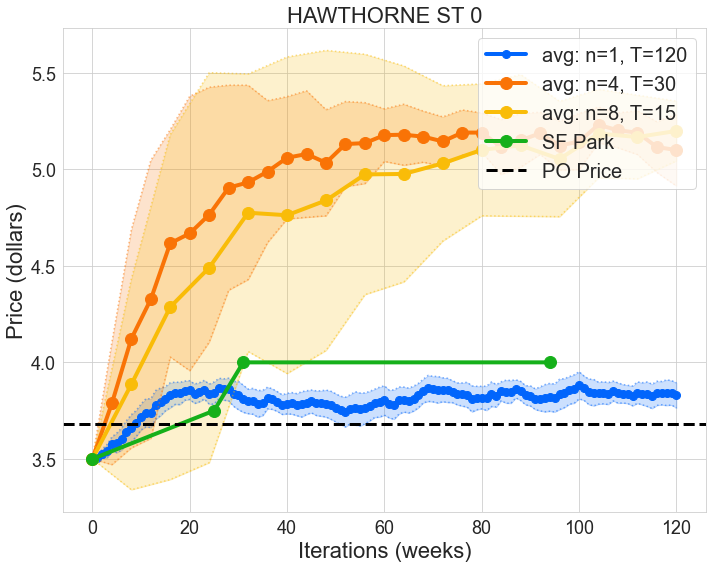

m: 0.019768084064327396
$\delta$: 0.9649371597974163
M=  0.2624716893868012


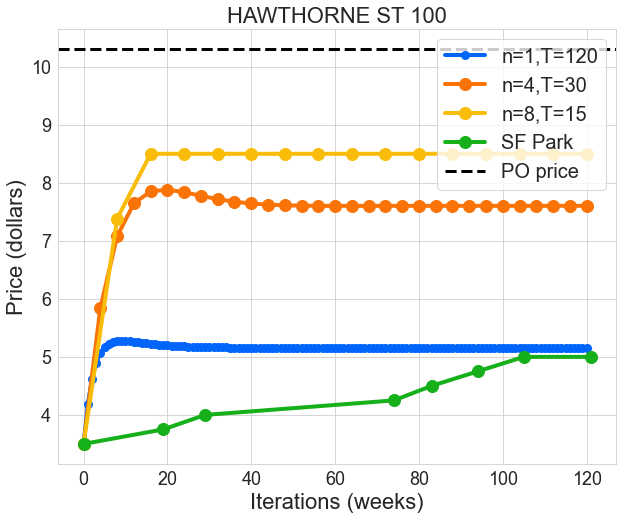

0
1
2


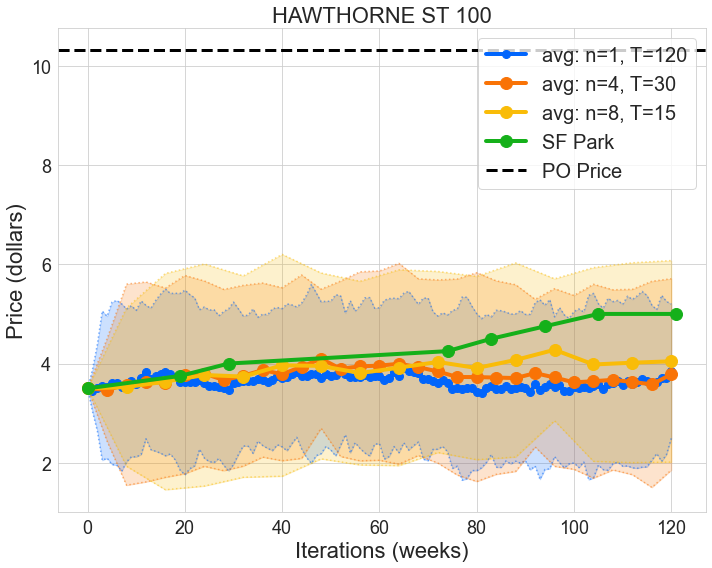

/Users/ratlifflj/repos/sandbox/2022/D3-parking/explicable/aaai_D3_supplement/code/sfpark_semisynthetic/ddutils.py:534: RuntimeWarning: divide by zero encountered in double_scalars
  return (final_occ - np.mean(np.random.choice(d, int(N), replace=True))) / theta


m: -inf
$\delta$: 1.0
M=  inf


/Users/ratlifflj/repos/sandbox/2022/D3-parking/explicable/aaai_D3_supplement/code/sfpark_semisynthetic/ddutils.py:537: RuntimeWarning: invalid value encountered in double_scalars
  return (l_star**2 * eta / alpha) ** (1/4)
/Users/ratlifflj/repos/sandbox/2022/D3-parking/explicable/aaai_D3_supplement/code/sfpark_semisynthetic/ddutils.py:540: RuntimeWarning: invalid value encountered in double_scalars
  return delta**n*d0+(1-delta**n)*(q+m*theta)
/Users/ratlifflj/repos/sandbox/2022/D3-parking/explicable/aaai_D3_supplement/code/sfpark_semisynthetic/ddutils.py:540: RuntimeWarning: invalid value encountered in multiply
  return delta**n*d0+(1-delta**n)*(q+m*theta)


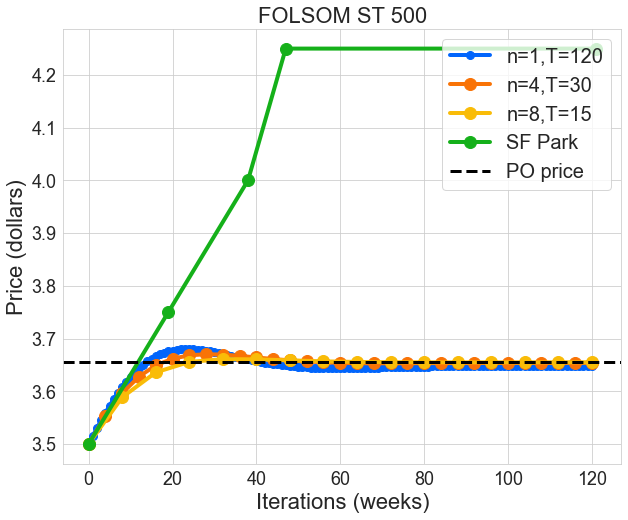

0
1
2


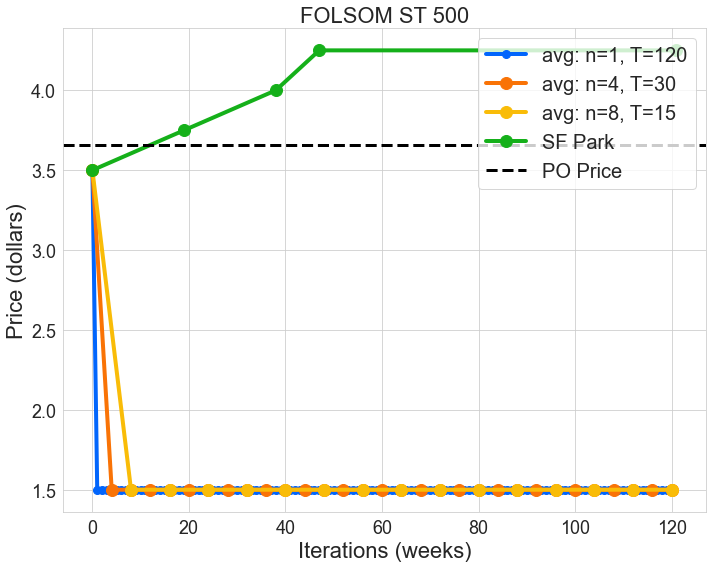

m: -0.13414736069672362
$\delta$: 0.7893371965712112
M=  0.70499457347247


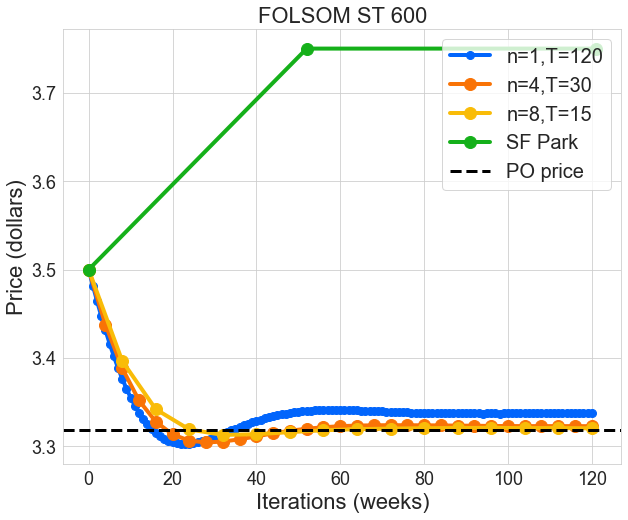

0
1
2


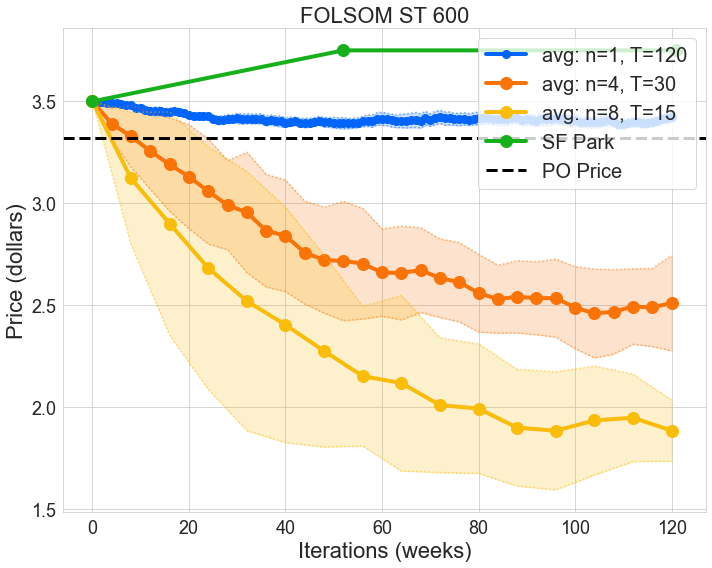

In [58]:
timewin=(900,1100)
pairs=[(1, 120),(4,30), (8, 15)] #, (15, 8), (40,3)]
SAVE=False
fo_data={}
zo_data={}
zo_vars_stds={}
starting_rate=3.5
for ind,(blk,street_name) in enumerate(zip(blks_all,street_names_all)):
    pre_occ=preoccs[street_name]
    ddp.setup(street_name, blk, timewin, pre_occ, starting_rate, num_days=5)
    
    ddp.runFOgrad(pairs)
    seeds=[np.random.randint(1,100) for i in range(100)]
    ddp.runZOgrad_(street_name, blk, starting_rate, 
                         pre_loaded_dataset=pre_occ,pairs=pairs) #np.arange(1,10))
    plt.figure(figsize=(10,8))
    palette = ['xkcd:bright blue', 'xkcd:orange', 'xkcd:golden rod', 'xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple'] #sns.color_palette("tab10", 5)
    sns.set_style("whitegrid")

    final_price_lst=[]
    for seed in ddp.seeds:
        for i,p in enumerate(pairs):
            n=p[0]; T=p[1]
            total = n*T
            x_coords = range(0, total + 1, n)
            marker = '-o'
            if n <= 3:
                markersize = 8
            else:
                markersize=12

            y_coords = np.asarray(ddp.data_current_run_fo[p,seed])+starting_rate
            final_price_lst.append(((n, T), y_coords[-1], estimate_occupancy(ddp.m, ddp.q, y_coords[-1]-starting_rate)))
            plt.plot(x_coords, y_coords, marker, color=palette[i], linewidth=4, markersize=markersize, label="n={},T={}".format(n, T))

    plt.plot(ddp.sf_park_xcoords, ddp.sf_park_ycoords, marker, color="xkcd:green", linewidth=4, markersize=markersize, label="SF Park")

    final_price_lst.append(("SF Park", ddp.sf_park_ycoords[-1], estimate_occupancy(ddp.m, ddp.q, ddp.sf_park_ycoords[-1]-starting_rate)))
    final_price_lst.append(("PO PRICE", ddp.theta_opt+starting_rate, estimate_occupancy(ddp.m, ddp.q, ddp.theta_opt)))
    final_price_lst.append(("FINAL OCCUPANCY FROM DATA", ddp.sf_park_ycoords[-1], ddp.end_occ))

    plt.axhline(y=ddp.theta_opt+starting_rate, linestyle='--', color='xkcd:black', label=r'PO price', linewidth=3)
    plt.legend(fontsize=20, loc=1, bbox_to_anchor=(1,1))
    plt.xlabel('Iterations (weeks)', fontsize=22)
    plt.ylabel('Price (dollars)', fontsize=22)
    plt.tick_params(labelsize=18)
    plt.title("{0} {1}".format(street_name, blk), fontsize=22)

    if SAVE:
        for tag in ['png','png']:
            plt.savefig('./figures/{0}_{1}_FO_plot_paper_app_mainfig2'.format(street_name, blk)+"."+tag)

    plt.show()
    
    fo_data[(blk,street_name)] = final_price_lst
    
    plt.figure(figsize=(10,8))
    palette = ['xkcd:bright blue', 'xkcd:orange', 'xkcd:golden rod', 'xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple'] #sns.color_palette("tab10", 5)
    sns.set_style("whitegrid")

    final_price_lst=[]
    ci=0

    plotit = ddp.zo_vars
    for i,p in enumerate(pairs):
        n=p[0]; T=p[1]
        total = n*T
        x_coords = range(0, total + 1, n)
        marker = '-o'
        if n <= 3:
            markersize = 8
        else:
            markersize=12

        y_coords = np.asarray(ddp.zo_avgs[p])+starting_rate
        final_price_lst.append(((n, T), y_coords[-1], estimate_occupancy(ddp.m, ddp.q, y_coords[-1]-starting_rate)))

        plt.plot(x_coords,np.asarray(ddp.zo_avgs[p])+starting_rate,label="avg: n={}, T={}".format(n, T), linewidth=4, 
                 color=palette[ci], marker='o', markersize=markersize)

        plt.plot(x_coords,(np.asarray(ddp.zo_avgs[p])+starting_rate+np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),), 
                 color=palette[ci], linestyle=':', alpha=0.5) #, label=r'$\pm 1$ std')
        plt.plot(x_coords,(np.asarray(ddp.zo_avgs[p])+starting_rate-np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),), 
                 color=palette[ci], linestyle=':', alpha=0.5)
        plt.fill_between(x_coords,(np.asarray(ddp.zo_avgs[p])+starting_rate+np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),),
                         (np.asarray(ddp.zo_avgs[p])+starting_rate-np.asarray(plotit[p])).reshape(len(ddp.zo_avgs[p]),), alpha=0.2, color=palette[ci])
        print(ci)

        ci+=1

    plt.plot(ddp.sf_park_xcoords, ddp.sf_park_ycoords, marker, color="xkcd:green", linewidth=4, markersize=markersize, label="SF Park")

    final_price_lst.append(("SF Park", ddp.sf_park_ycoords[-1], estimate_occupancy(ddp.m, ddp.q, ddp.sf_park_ycoords[-1]-starting_rate)))
    final_price_lst.append(("PO PRICE", ddp.theta_opt+starting_rate, estimate_occupancy(ddp.m, ddp.q, ddp.theta_opt)))

    plt.axhline(y=ddp.theta_opt+starting_rate, linestyle='--', color='xkcd:black', label="PO Price", linewidth=3)
    plt.legend(fontsize=20, loc=1, bbox_to_anchor=(1,1))
    plt.xlabel('Iterations (weeks)', fontsize=22)
    plt.ylabel('Price (dollars)', fontsize=22)
    plt.tick_params(labelsize=18)
    plt.title("{0} {1}".format(street_name, blk), fontsize=22)
    plt.tight_layout()
    zo_vars_stds[(blk, street_name)]=[ddp.zo_vars, ddp.zo_stds]
    if SAVE:
        for tag in ['png','png']:
            plt.savefig('./figures/{0}_{1}_ZO_plot_paper_app_mainfig2'.format(street_name, blk)+"."+tag)
    plt.show()
    zo_data[(blk,street_name)]=final_price_lst

In [59]:
price={}
occ_h={}
(n,T)=(8,15)
blocks=blks_3rd
R=1.5
Rmax= 8-starting_rate# 8 dollars is the max
Rmin=-3.5
zo_variance=[]
zo_stdev=[]
for blk,street_name in zip(blocks,street_names_all):
    price[(str(blk),street_name)]=[]

    for item in fo_data[(blk,street_name)]:
        if item[0] == (n, T):
            fo_price = item[1]
            fo_occ = item[2]
        elif item[0] == "SF Park":
            sfpark_price = item[1]
            sfpark_occ = item[2]
        elif item[0] == "PO PRICE":
            #if item[1]>R:
            #    po_price = R
            #if item[1]
            po_price = min(max(Rmin,item[1]-3.5), Rmax)  +3.5
            print(blk, street_name, item[1], po_price)
            po_occ = 0.7 #item[2]
        elif item[0] == "FINAL OCCUPANCY FROM DATA":
            sfpark_occ_from_data = item[2]
    
    zo_price = 0
    zo_occ = 0
    (n,T)=(1,120)
    for item in zo_data[(blk,street_name)]:
        if item[0] == (n, T):
            zo_price = item[1]
            zo_occ = item[2]
            break
    price[(str(blk),street_name)]=[sfpark_price, fo_price, zo_price, po_price]
    occ_h[(str(blk),street_name)]=[sfpark_occ,fo_occ,zo_occ,po_occ]
    zo_variance.append(zo_vars_stds[(blk,street_name)][0][(1,120)][0])
    zo_stdev.append(zo_vars_stds[(blk,street_name)][1][(1,120)][0])
    
df_=pd.DataFrame(price).T
df_o=pd.DataFrame(occ_h).T

df_.columns=[ 'SFPark', 'FO', 'ZO', 'PO']
df_o.columns=[ 'SFPark', 'FO', 'ZO', 'PO']

labels=[street_name+" "+str(blk) for blk,street_name in zip(blocks,street_names_all)]
zo=np.asarray(df_['ZO'])
fo=np.asarray(df_['FO'])
sf=np.asarray(df_['SFPark'])
po=np.asarray(df_['PO'])

zo_o=np.asarray(df_o['ZO'])
fo_o=np.asarray(df_o['FO'])
sf_o=np.asarray(df_o['SFPark'])
po_o=np.asarray(df_o['PO'])

0 HAWTHORNE ST 3.680651039689425 3.680651039689425
100 HAWTHORNE ST 10.312948635853566 8.0
500 FOLSOM ST 3.655624139652253 3.655624139652253
600 FOLSOM ST 3.318799113136577 3.318799113136577


In [60]:
zo_variance

[0.0, 0.0, 0.0, 0.0]

4
0
1
2
3
0 3.680651039689425
1 8.0
2 3.655624139652253
3 3.318799113136577


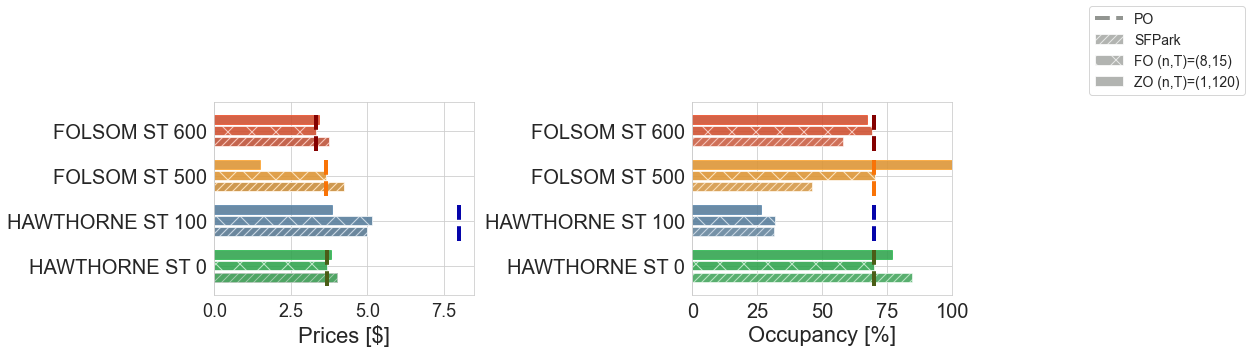

In [62]:


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
cols=['xkcd:kelly green', 'xkcd:muted blue', 'xkcd:tangerine', 'xkcd:tomato red', 'xkcd:purple', 'xkcd:hot pink']
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

xmins=x-1/4-0.1-0.1
xmaxs=x+1/4+0.1+0.1
print(len(xmins))
rects1 = ax[1].barh(x - 1/4, sf_o*100, width, label='SFPark',edgecolor='white', color='xkcd:grey', alpha=0.7, hatch="///")
rects2 = ax[1].barh(x , fo_o*100, width, label='FO (n,T)=(8,15)',  color='xkcd:grey', hatch="x", alpha=0.7)
rects3 = ax[1].barh(x + 1/4, zo_o*100, width,xerr=np.asarray(zo_stdev)*100, label='ZO (n,T)=(1,120)', color='xkcd:grey', alpha=0.7)
p=70
ax[1].vlines(x=70, ymin=xmins[len(labels)-1], ymax=xmaxs[len(labels)-1], linewidth=4, color='xkcd:grey', linestyle='--', label='PO')


ax[1].legend(fontsize=14, loc=0, bbox_to_anchor=(1.5,1))

rects1 = ax[1].barh(x - 1/4, sf_o*100, width, label='SFPark',edgecolor='white', color=cols, alpha=0.5, hatch='///')
rects2 = ax[1].barh(x , fo_o*100, width, label='FO', color=cols, hatch="x", alpha=0.6)
rects3 = ax[1].barh(x + 1/4, zo_o*100, width, label='ZO', color=cols,edgecolor=cols, alpha=0.6)

#ax[1].text( 0.825,x[0]+1/4-0.15, '(1,120)', ha='center', va='bottom', fontsize=16)
colsalt=['xkcd:army green', 'xkcd:royal blue', 'xkcd:orange', 'xkcd:dark red', 'xkcd:dark purple', 'xkcd:magenta']

for i,p in enumerate(po_o):
    print(i)
    ax[1].vlines(x=70, ymin=xmins[i], ymax=xmaxs[i], linewidth=4, color=colsalt[i], linestyle='--')
ax[1].set_xlabel('Occupancy [%]', fontsize=22 )
ax[1].set_xlim([0,100])

rects1 = ax[0].barh(x - 1/4, sf, width, label='SFPark',edgecolor='white', color='xkcd:grey', alpha=0.9, hatch="///")
bar = ax[0].patches[0]
#bar.set_hatchcolor('white')
bar.set_edgecolor([0.5,0.5,0.5])
rects2 = ax[0].barh(x , fo, width, label='FO',  color='xkcd:grey', hatch="x", alpha=0.7)
rects3 = ax[0].barh(x + 1/4, zo, width, label='ZO', color='xkcd:grey', alpha=0.7)

rects1 = ax[0].barh(x - 1/4, sf, width, label='SFPark',edgecolor="white", color=cols, alpha=0.5, hatch='///')
rects2 = ax[0].barh(x , fo, width, label='FO', color=cols, hatch="x", alpha=0.6)
rects3 = ax[0].barh(x + 1/4, zo, width, label='ZO', color=cols,edgecolor=cols, alpha=0.6)

#colsalt=['xkcd:army green', 'xkcd:royal blue', 'xkcd:orange', 'xkcd:dark red']
xmins=x-1/4-0.1-0.1
xmaxs=x+1/4+0.1+0.1
for i,p in enumerate(po):
    print(i,p)
    ax[0].vlines(x=p, ymin=xmins[i], ymax=xmaxs[i], linewidth=4, color=colsalt[i], linestyle='--')
ax[0].set_xlabel('Prices [$]', fontsize=22 )
#ax.set_title()
#ax.set_xticklabels(x,labels)
plt.tick_params(labelsize=20)
plt.yticks(x, labels)
ax[0].set_xlim([0,8.5])
fig.tight_layout()
ax[0].tick_params(labelsize=18)
ax[0].set_yticks(x) 
ax[0].set_yticklabels(labels, fontsize=20)

if SAVE:
    for tag in ['png', 'pdf']:
        print('saving : occprice_n={}_T={}_.'.format(str(n),str(T)))
        plt.savefig('./figures/occprice_n={}_T={}_'.format(str(n),str(T))+"_demo."+tag, transparent = True, bbox_inches='tight', dpi=300 )